# Two dimensional Cartesian Slepians, generalized

The idea here is to use slepian_foxtrot to jumpstart an implementation of the Simons code. We should be able to then localize blobs, or splined boundaries of things in order to get the GL nodes and solve the concentration problem. 

`slepian_foxtrot` depends on `slepian_alpha`, so the routines from `slepian_alpha` that are needed have been collected in an input file. 

In [1]:
using FastGaussQuadrature, Plots

In [2]:
# This code originated with slepian_foxtrot by Simons and Wang, 2010
circn = 41
XY = hcat(cos.(LinRange(0, 2*pi, circn)), sin.(LinRange(0, 2*pi, circn)))
N = 20
method = :GL
size(XY,2) != 2 && error("XY must have 2 columns")
xlimt = [minimum(XY[:,1]), maximum(XY[:,1])]
xrange = xlimt[2] - xlimt[1]
ylimt = [minimum(XY[:,2]), maximum(XY[:,2])]
yrange = ylimt[2] - ylimt[1]
dxdy = [5.0, 5.0]/100
println("Resolution $dxdy")

Resolution [0.05, 0.05]


In [3]:
sign(x) = (x >= 0.0) ? 1 : -1

include("relevant_slepian_alpha.jl")

#=
dv, foldi, be = degamini([1, 2, 2, 3])

matranges([1, 4, 1, 2, -1, 2])

# Demo2 requires blobs (?)

xx, yy = blob()
plot(xx[1], yy[1])
plot!(xx[2], yy[2])
plot!(xx[3], yy[3])

# Testing complete
=#

blob

In [55]:
data = [1, 2, 3, 1, 4, 5]
folding = [1, 2, 3, 2, 4, 2]
degamini(gamini(data,folding))

([1, 2, 3, 1, 4, 5], [1, 2, 3, 2, 4, 2], [1 1; 2 3; … ; 9 12; 13 14])

In [20]:
# if method == :GL
Nqx = 32
Nqy = 32
println("Gauss-Legendre method with ($Nqx, $Nqy) integration nodes.")
# Calculate blanks, xaxis GL points regardless of the data range
using FastGaussQuadrature
wqx, qx = FastGaussQuadrature.gausslegendre(Nqx)
wqy, qy = FastGaussQuadrature.gausslegendre(Nqy)

using Random
Random.seed!(123)
x, y = blob(1,1)
thph = hcat(y[1], x[1]) 
Nth = Int64(floor(rand(1)[1]*300))
th = LinRange(minimum(thph[:,1]), maximum(thph[:,1]), Nth)

# For each of these points in y find the appropriate ranges of x's
# xints, yp, xp, forreal = phicurve(thph, qy) # Line 128 of Localization2D.m
th = qy
# end

using DelimitedFiles
writedlm("testphint_thph.txt", thph, ",")
writedlm("testphint_th.txt", th, ",")

phint_matlab = readdlm("phint.txt", ',')
thp_matlab = readdlm("thp.txt", ',')
php_matlab = readdlm("php.txt", ',')
forreal_matlab = readdlm("forreal.txt", ',')


Gauss-Legendre method with (32, 32) integration nodes.


32×2 Array{Float64,2}:
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 ⋮    
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0

In [58]:
#=
""" 

    phicurve(thph, th)

Adapted from slepian_alpha; finds the longitude crossings and thus integration domains of a closed curve parameterized in colatitude/longitude space at certian query points of colatitude.

# Arguments
- `thph::` Colatitude/longitude of the closed curve (degrees)
- `th::` Colatitude at which crossings are required (degrees)

# Outputs
- `phint` A matrix with crossings/intervals and zeros of dimensions MxN where M = length(th) and N can be anything depending on the oscillations of the curve
- `thp` Colatitude matrix for hatched plotting, if possible
- `php` Longitude matrix for hatched plotting, if possible
- `forreal` Indices of the ones that are real (could be at zero)

Depends on: @sub2ind, @interp1, @degamini, @matranges, and possibly @blob (demo2)
"""
function phicurve(thph, th)
=#
    # Fore every th, find the relevant phint
    xmth = repeat(thph[:,1], 1, length(th)) .- repeat(th', length(thph[:,1]), 1)
    dsx = diff(sign.(xmth), dims = 1)
    # It can be the one before, or after the crossing
    # colf, colj = findall(x -> (x != 0.0), dsx)
    col = findall(x -> (x != 0.0), dsx)
    colf, colj = (map(c -> Tuple(c)[1], col), map(c -> Tuple(c)[2], col))
    # colr = sub2ind(dsx, colf, colj) 
    colr = LinearIndices(dsx)[col]
    # This returns the one on the negative side of hte line
    colx = colf .+ (dsx[colr] == -2)
    colx2 = colx .- (dsx[colr] == -2) .+ (dsx[colr] == 2)
    L = length(colx)
    (L%2 == 1) && error("Cannot find pairs of crossings.")
    phint = zeros(L)
    # Then one point was exactly hit, this is the thN or the thS case
    if length(colx) == 2 && colx == colx2
        phint = thph[hcat(colx[2], colx2[2]), 2]
        thp = [th, th]
        php = phint
    else
        for ond = 1:L
            # In case you have a node immediately followed by a crossing
            phint[ond] = (colx[ond] == colx2[ond]) ? NaN : interp1(xmth[hcat(colx[ond], colx2[ond])], colj[ond], thph(hcat(colx[ond], colx2[ond]),2), 0, :linear) 
        end
    end
    # If the NaNs are not consecutive pairs, get special case
    # Now rearrange back othte number of requested points
    # There could be points with more or less than two crossings
    # Maximum number of times a crossing is repeated
    a, b =  degamini(colj) 
    rowj = colj
    colj = matranges(Int64.(reshape(hcat(ones(length(b)), b)', length(b)*2, 1)))
    pint = repeat([NaN], length(th), maximum(b))
    subsi = (colj .- 1) .* length(th) .+ rowj # Linear index
    pint[subsi] = phint
    wt, thp = (length(b) == length(th)) ? (0, reshape(gamini(th, b), (2, Int64(length(phint)/2)))) : (1, [])
    # Need to sort since contour may be given in any order
    phint = sort(pint, dims = 2)
    php = (wt == 0) ? reshape(phint[subsi], (2, Int64(length(colj)/2))) : [] # line 95
    # Make them zero so the integral doesn't do anything
    forreal = findall(x -> !isnan(x), phint)
    phint[findall(isnan, phint)] .= 0.0
    # note: can use (demo2)
    # x,y=blob(1,1); thph=hcat(y[:],x[:]); Nth = ceil(rand*300); th=LinRange(minimum(thph[:,1]), maximum(thph[:,1]), Nth)
    return phint, thp, php, forreal
#end


([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [0.007018610009470092 0.016274394730905625 … 0.016274394730905625 0.007018610009470092; 0.007018610009470092 0.016274394730905625 … 0.016274394730905625 0.007018610009470092], [NaN NaN … NaN NaN; NaN NaN … NaN NaN], CartesianIndex{2}[])

In [38]:
length(colx) == 2 && colx == colx2

false

In [59]:
forreal_matlab ≈ forreal

LoadError: [91mDimensionMismatch("dimensions must match: a has dims (Base.OneTo(32), Base.OneTo(2)), b has dims (Base.OneTo(0),), mismatch at 1")[39m

In [26]:
php_matlab ≈ php

true

In [25]:
thp_matlab ≈ thp

true

In [60]:
phint, phint_matlab

([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [-1.312949931431483 1.540448886346207; -1.310781785536589 1.545135108224483; … ; -1.310781785536589 1.545135108224483; -1.312949931431483 1.540448886346207])

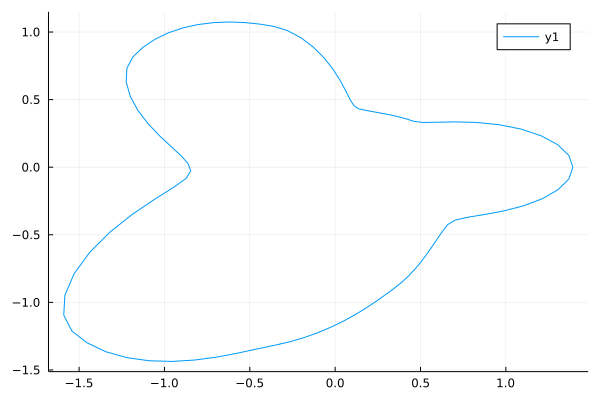

In [65]:
using DelimitedFiles

# Computed using blob(1,1) in matlab with rng(123) seed. 
xy = readdlm("blob11.txt", ',')

plot(xy[:,1], xy[:,2])

In [38]:
col = findall(x -> (x != 0.0), dsx)
map(c -> Tuple(c)[1], col)

112-element Array{Int64,1}:
  2
 50
  3
 50
  3
 50
  3
 50
  4
 40
 41
 49
  4
  ⋮
  4
 40
 41
 49
  3
 50
  3
 50
  3
 50
  2
 50